# 🐡 The sharp points of Rockpool 🐚

In [6]:
# - Rockpool imports
from rockpool import TSContinuous

# - General imports and configuration
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

## 🦀 How to use sampled time series data (in)correctly in Rockpool
Time series data loaded from elsewhere probably comes in a clocked raster format. You can easily use this data in Rockpool, but there are a couple of tricky points to watch out for.

Wrong: how to generate a time base

In [7]:
# Sampling rate
fs = 16000

# Time step
dt = 1/fs

# Numer of samples
num_samples = 100

# Generate dummy samples
data_samples = [np.random.rand(fs) for _ in range(num_samples)]

step = 0
t = 0.
for data in data_samples:
    t = np.random.rand() + 20000
    time_base = np.arange(t, t + len(data) / fs, 1/fs)
    assert len(time_base) == len(data), 'WTF?'
    step += len(data)
    t = step * dt

In [8]:
t

100.0

Wrong: how to define a correct time series for clocked data

Ok, we have a 20-second sample, sampled on a 100ms clock.

In [9]:
dt = 0.1
data = np.random.rand(200)
time_base = np.arange(len(data)) * dt

ts = TSContinuous(time_base, data)
ts

non-periodic TSContinuous object `unnamed` from t=0.0 to 19.900000000000002. Samples: 200. Channels: 1

Huh? The time series is too short, it's one `dt` off! But there are 200 samples...?

Time series objects don't have an intrisic clock; you can define samples at any point in time. So they have no way to know that you expected a 20 second duration. By default, the time series ends at the point in time where the last sample occurs. But for clocked data, you probably expected there to be an extra `dt`.

The correct low-level way to define the time series is to specify `t_stop` explicitly:

In [10]:
ts = TSContinuous(time_base, data, t_stop = 20.)
ts

non-periodic TSContinuous object `unnamed` from t=0.0 to 20.0. Samples: 200. Channels: 1

In [11]:
ts = TSContinuous.from_clocked(data, dt=dt)
ts

non-periodic TSContinuous object `unnamed` from t=0.0 to 20.000000000000004. Samples: 200. Channels: 1

## 🐚 Defining extents for `TSEvent` time series data

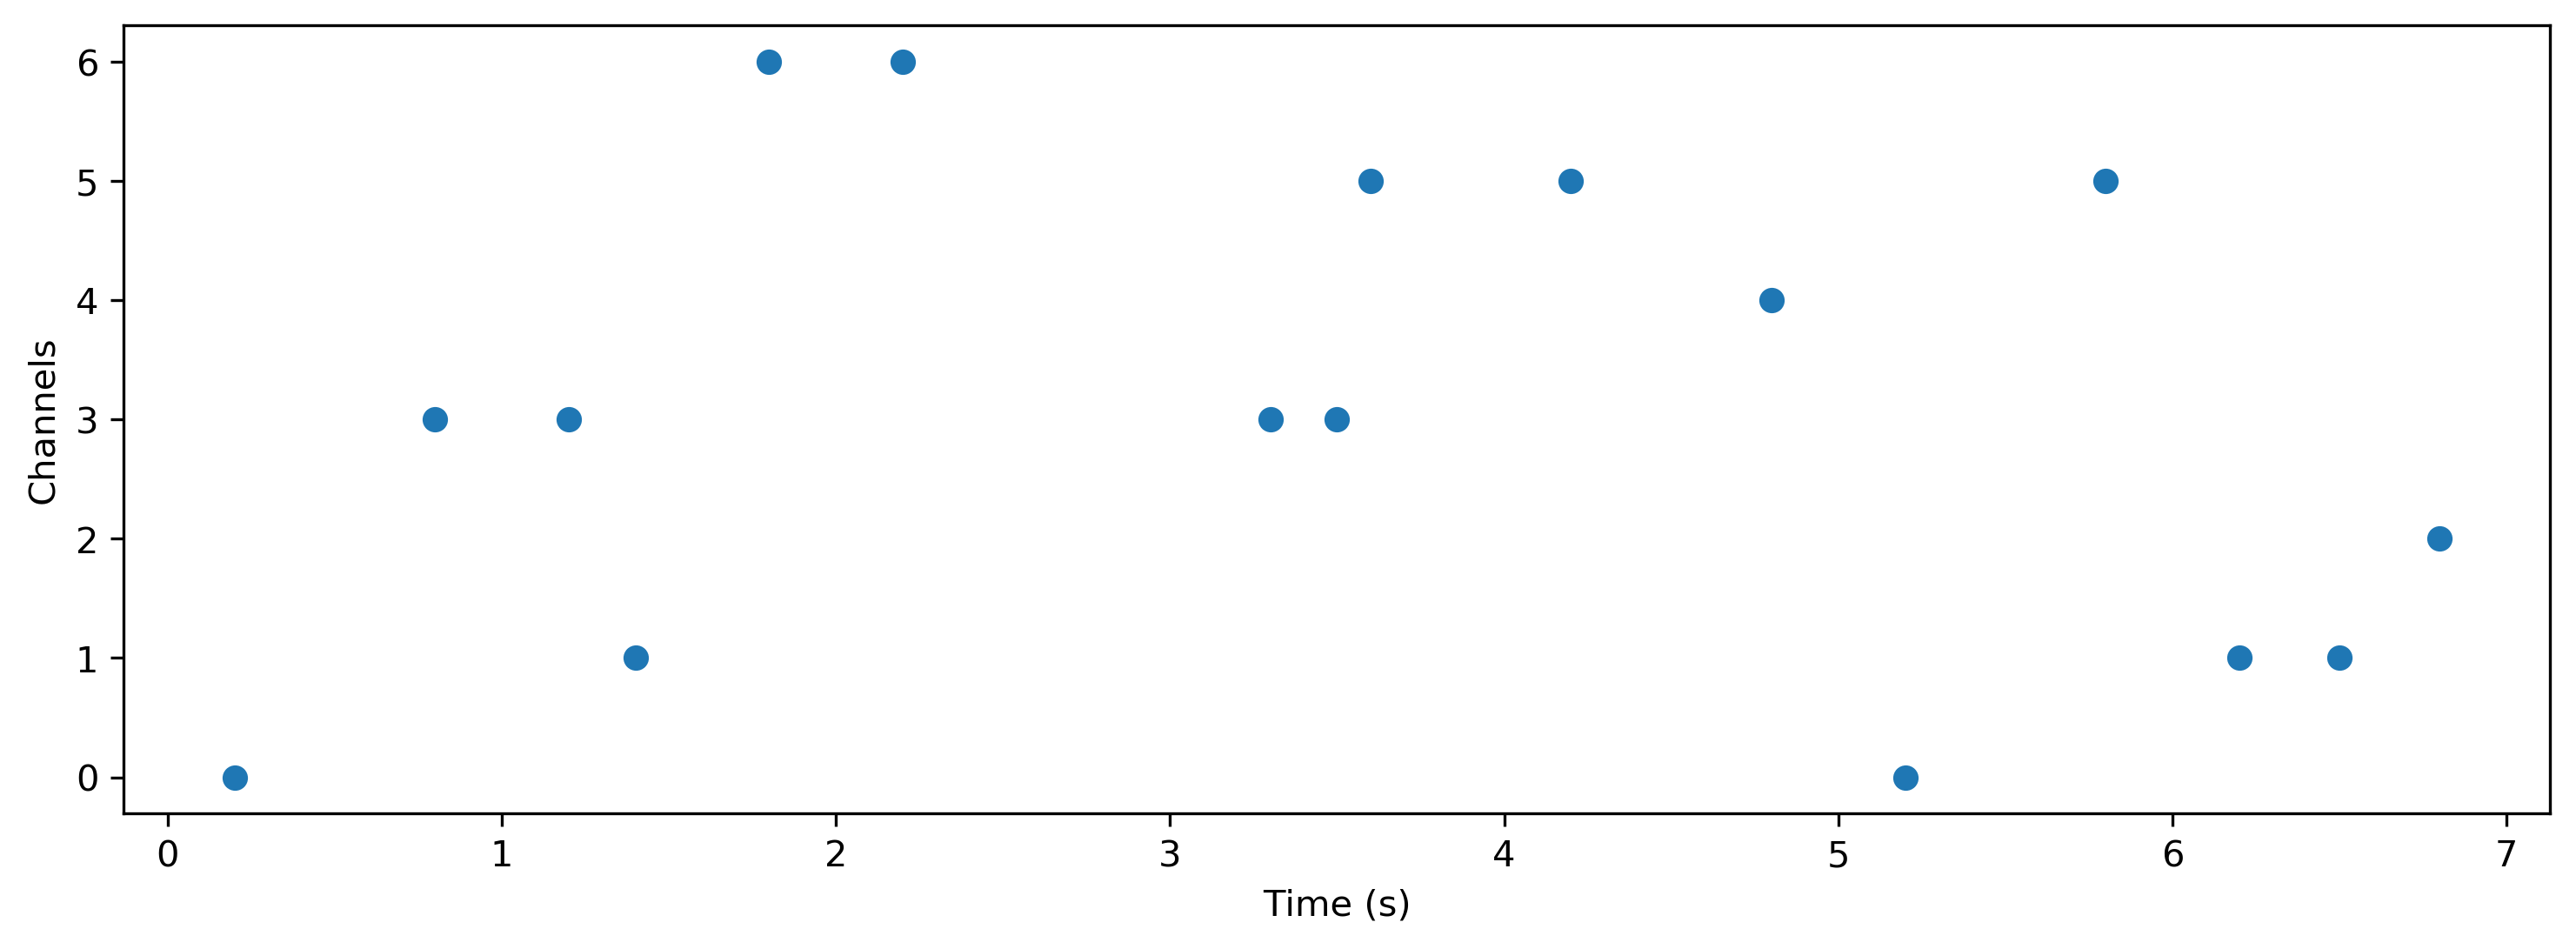

In [12]:
from rockpool import TSEvent
from matplotlib import pyplot as plt

times = [.2, .8, 1.2, 1.4, 1.8, 2.2, 3.3, 3.5, 3.6, 4.2, 4.8, 5.2, 5.8, 6.2, 6.5, 6.8]
channels = [0, 3, 3, 1, 6, 6, 3, 3, 5, 5, 4, 0, 5, 1, 1, 2]
ts = TSEvent(times, channels, t_start = 0., t_stop = 7.)
ts.plot();

<img src="TSEvent_to_raster.png" />

non-periodic `TSEvent` object `unnamed` from t=0.0 to 7.0. Channels: 7. Events: 16


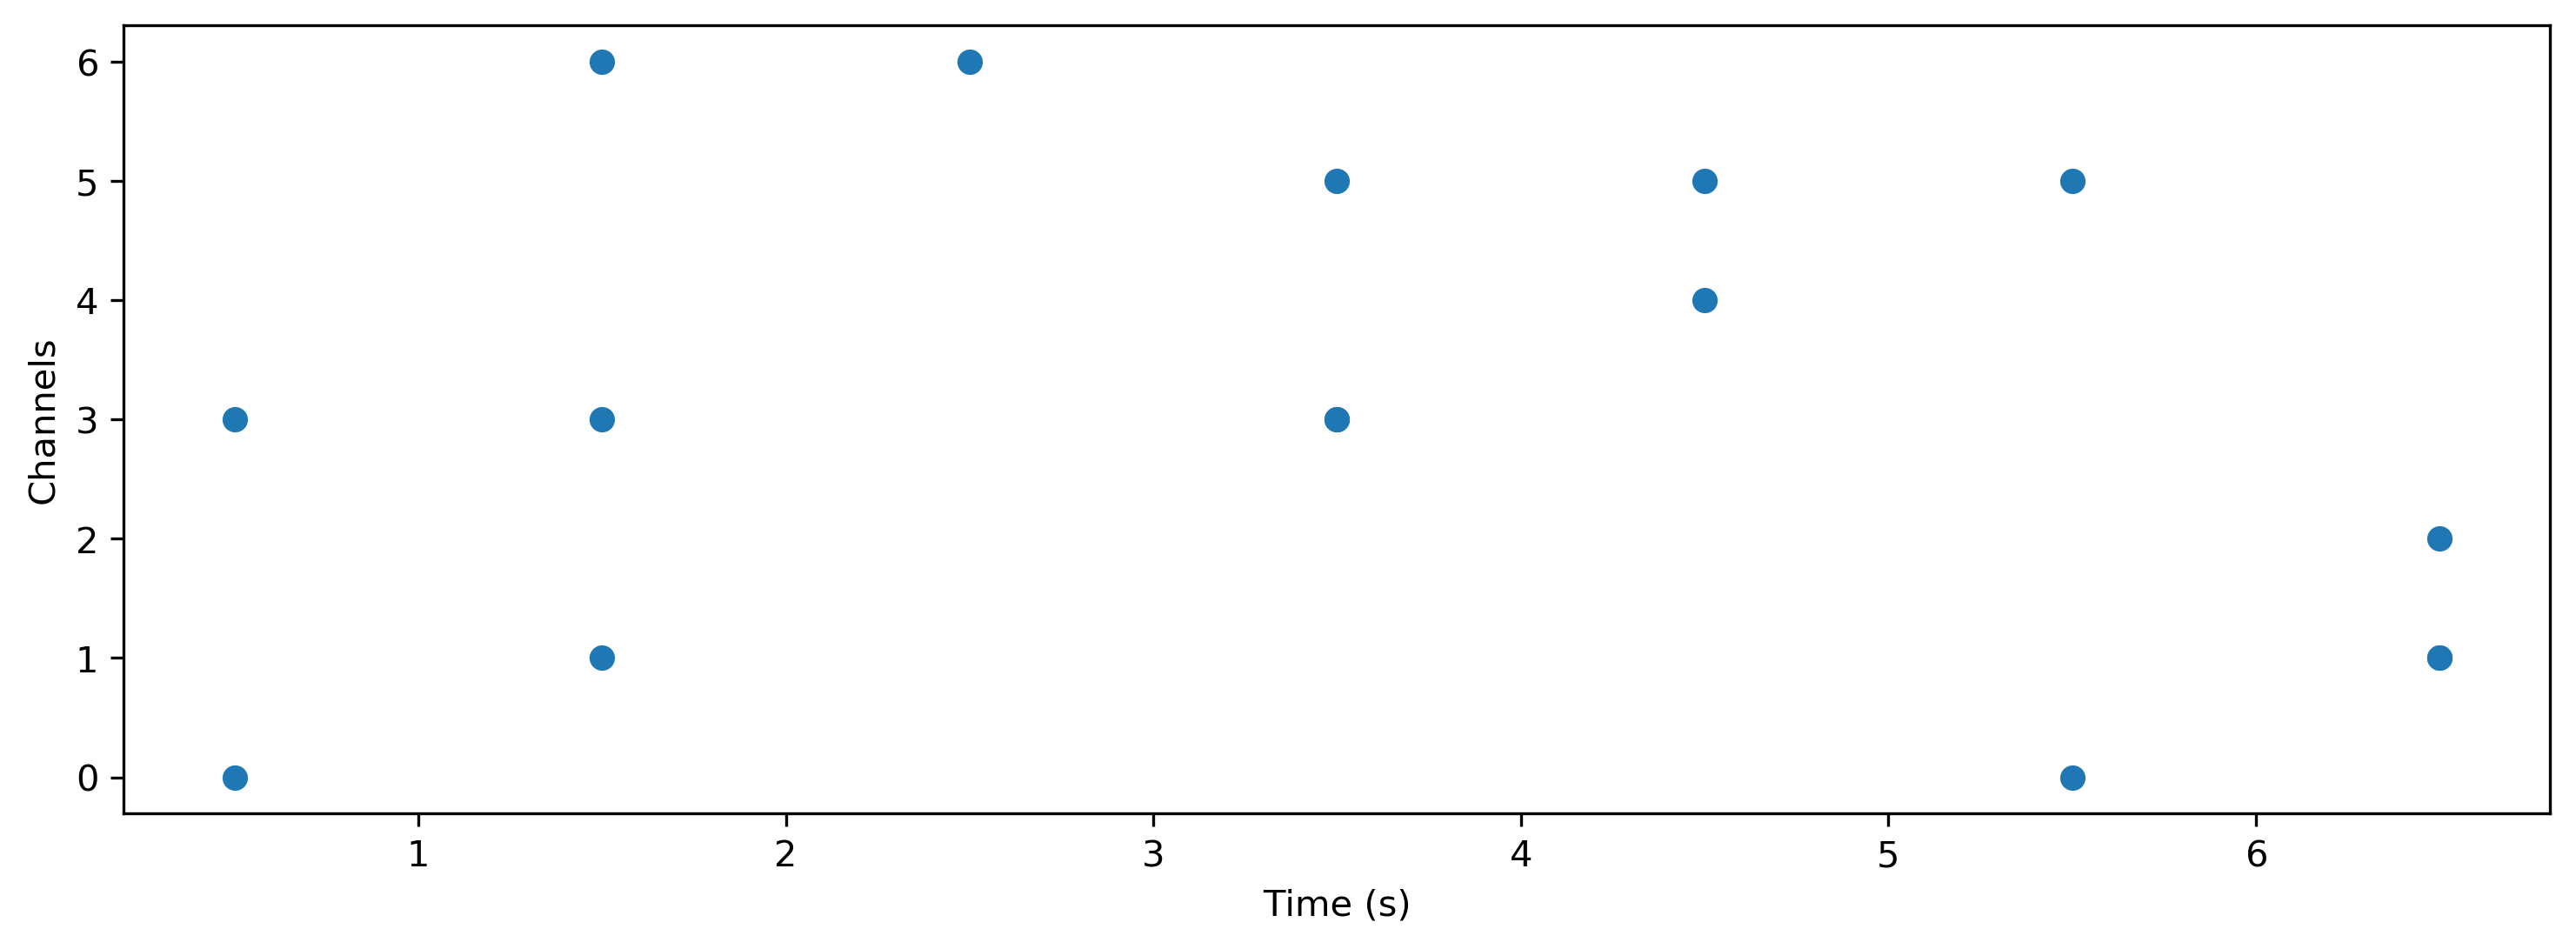

In [13]:
ts2 = TSEvent.from_raster(ts.raster(dt = 1., add_events = True), dt = 1.)
print(ts2)
ts2.plot();

In [14]:
from rockpool import TSContinuous
import numpy as np

time_low_res = np.arange(0, 1, 0.02)
time_high_res = np.arange(0, 1, 0.001)
ts = TSContinuous(time_low_res, np.random.rand(len(time_low_res)))
# ts(time_high_res) # <-- contains NANs


In [15]:
ts

non-periodic TSContinuous object `unnamed` from t=0.0 to 0.98. Samples: 50. Channels: 1

## `TimeSeries` and `Layer`s share an explicit global time base

In [16]:
# - Imports
from rockpool.layers import FFRateEuler
from rockpool import TSContinuous

# - Define a layer
lyr = FFRateEuler([1], dt = 1e-3)
print('lyr:', lyr)

# - Define a time series
data = np.random.rand(100)
ts_input = TSContinuous.from_clocked(data, dt = .1)
print('ts_input:', ts_input)

lyr: FFRateEuler object: "unnamed" [1 TSContinuous in -> 1 internal -> 1 TSContinuous out]
ts_input: non-periodic TSContinuous object `unnamed` from t=0.0 to 10.0. Samples: 100. Channels: 1


Now we evolve `lyr` using `ts_input`, and look at the result.

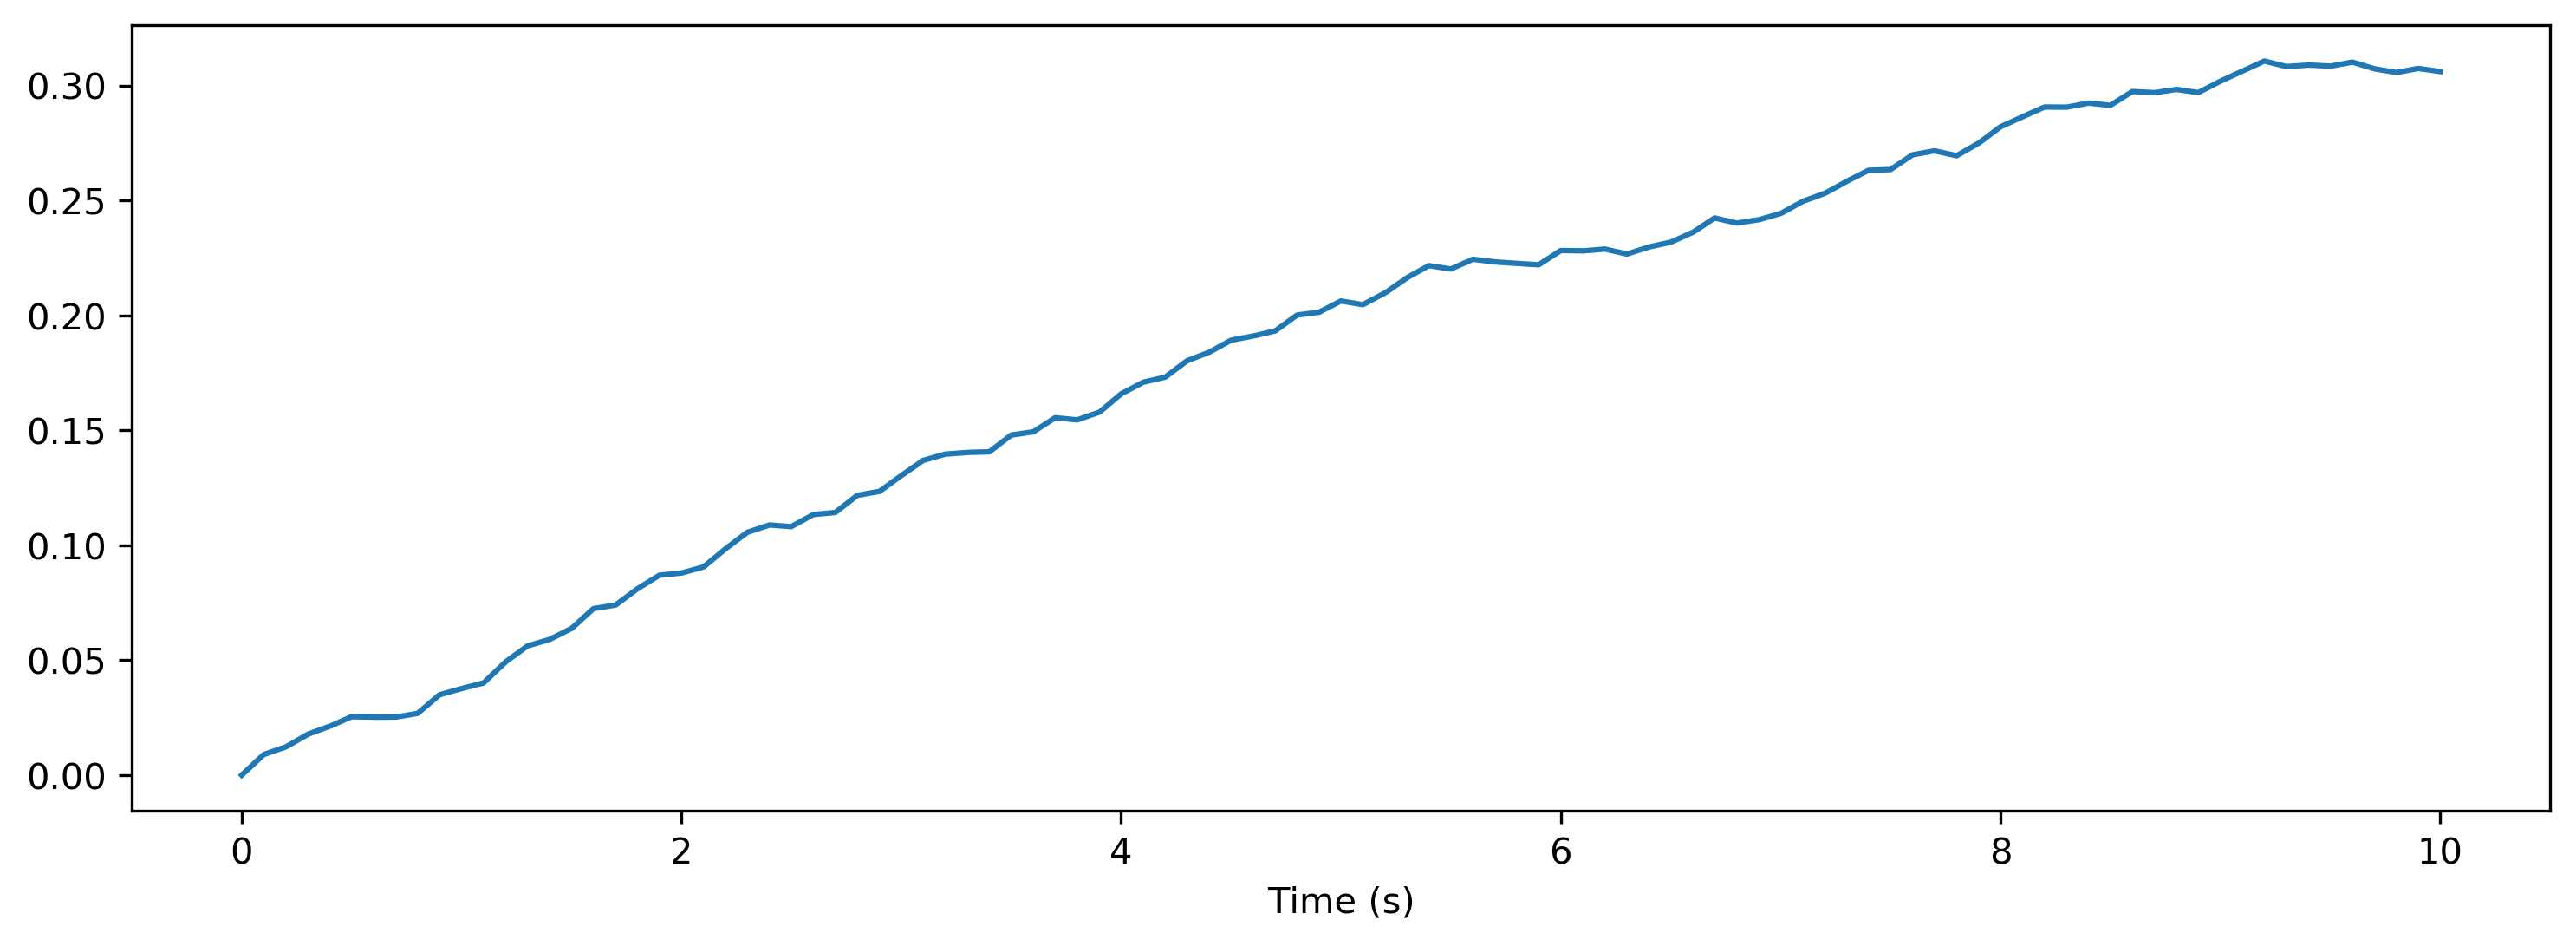

In [17]:
lyr.evolve(ts_input).plot()

But now if we evolve `lyr` again, we recieve an error.

In [18]:
lyr.evolve(ts_input)

AssertionError: Layer `unnamed`: Cannot determine an appropriate evolution duration. `ts_input` finishes before the current evolution time.

In [19]:
print('lyr.t:', lyr.t)
print('ts_input:', ts_input)

lyr.t: 10.0
ts_input: non-periodic TSContinuous object `unnamed` from t=0.0 to 10.0. Samples: 100. Channels: 1


In [20]:
ts_input(10.1)

array([[nan]])

WARNING    /Users/dylan/aiCTX Dropbox/Dylan Muir/LiveSync/Development/rockpool_GIT/rockpool/layers/layer.py:224: UserWarning: Layer `unnamed`: Evolution period (t = 10.0 to 20.0) is not fully contained in input signal (t = 0.0 to 10.0). You may need to use a `periodic` time series.
  + " You may need to use a `periodic` time series."
 [py.warnings]


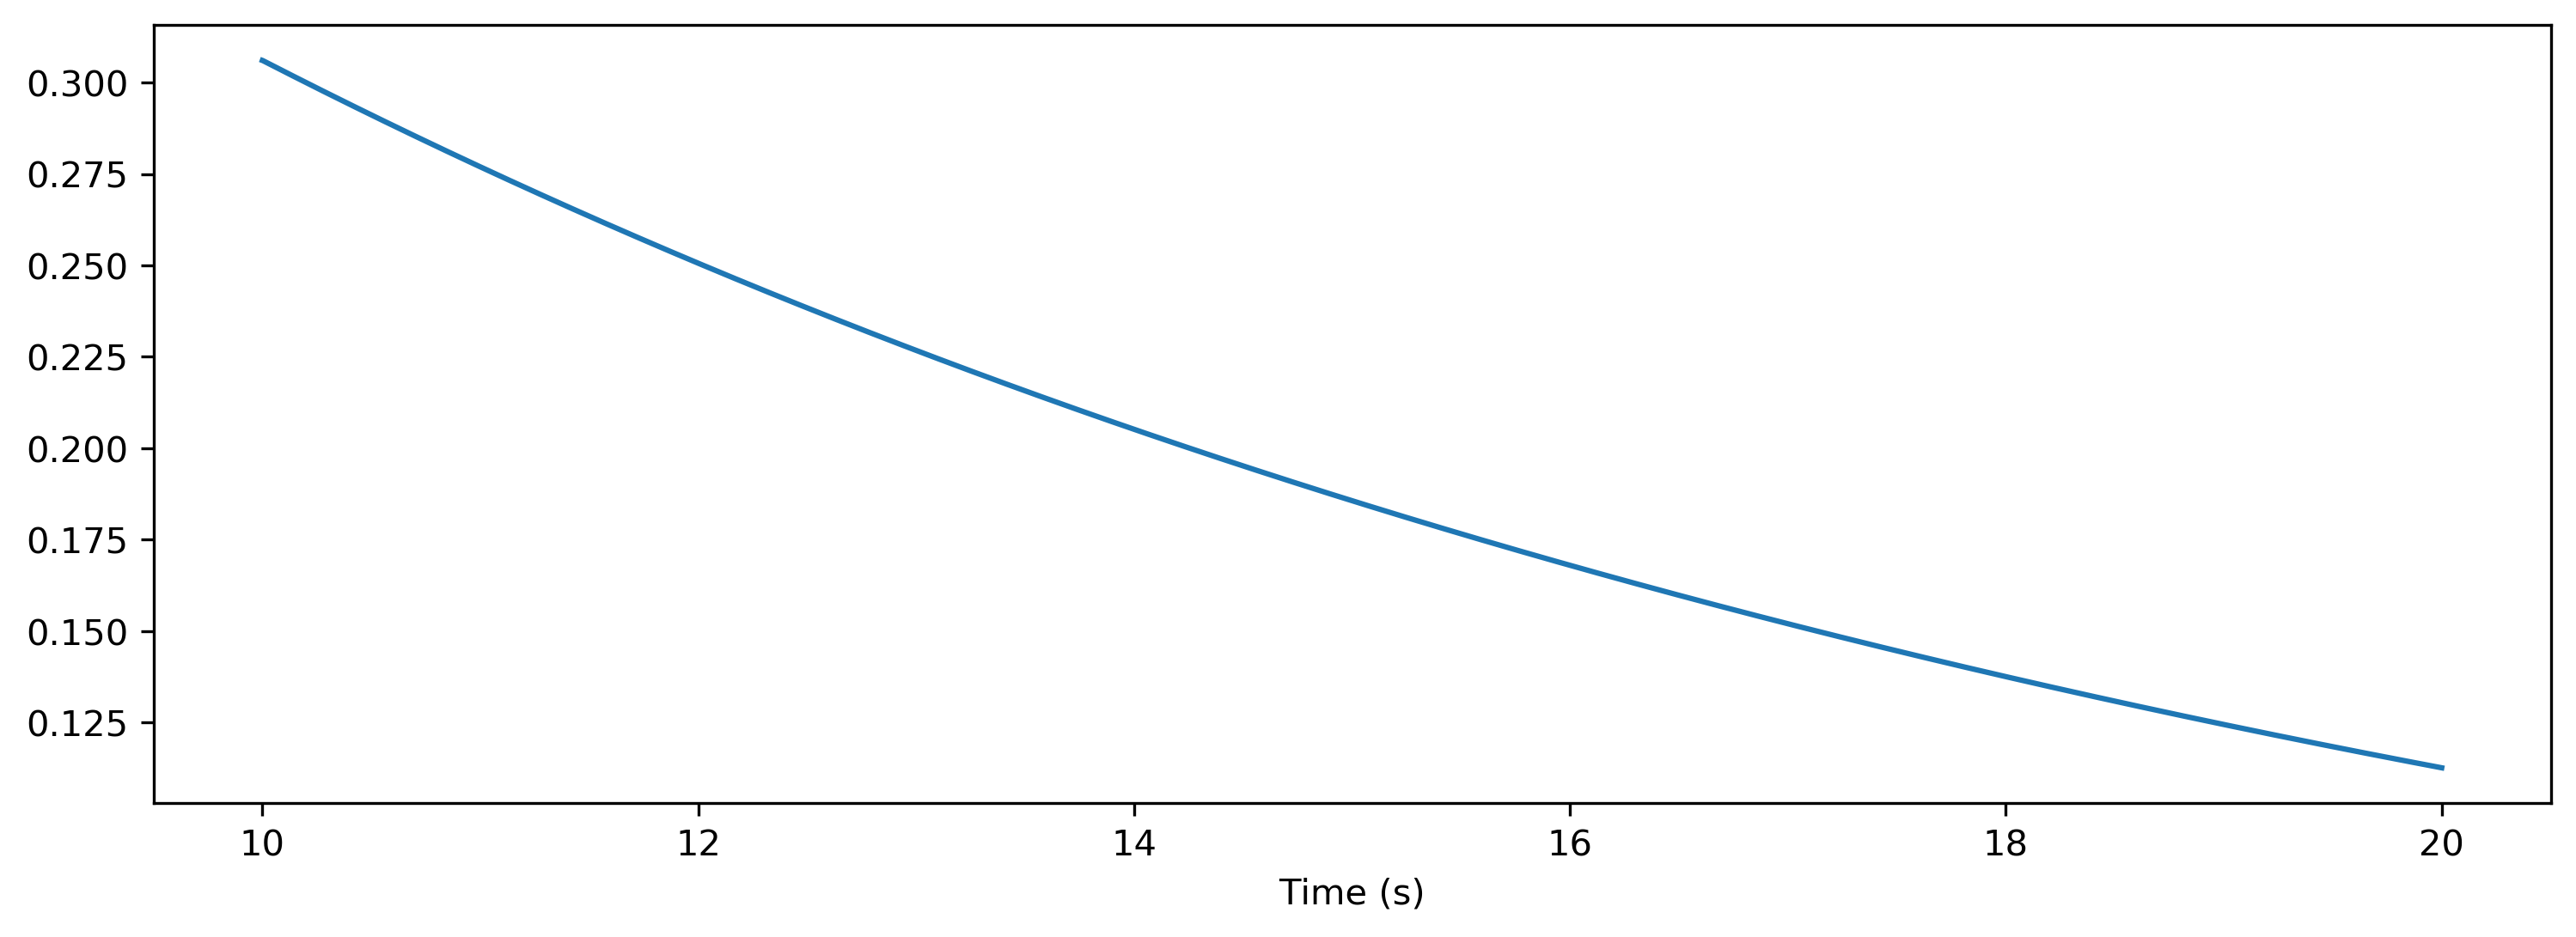

In [21]:
lyr.evolve(ts_input, duration = 10).plot();

In [22]:
# - Define a time series
ts_input = TSContinuous.from_clocked(data, dt = .1, t_start = lyr.t)
print('ts_input:', ts_input)

ts_input: non-periodic TSContinuous object `unnamed` from t=20.0 to 30.0. Samples: 100. Channels: 1


In [29]:
# - Using `.start_at()`
lyr.evolve(ts_input.start_at(lyr.t))

# - Using `.delay()`
lyr.evolve(ts_input.delay(lyr.t - ts_input.t_start))

non-periodic TSContinuous object `unnamed` from t=100.0 to 110.0. Samples: 10001. Channels: 1

In [30]:
ts_input = TSContinuous.from_clocked(data, dt = .1, periodic = True)

TypeError: from_clocked() got an unexpected keyword argument 'periodic'